# Gemma Model for Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('news_less_clean.csv')

In [3]:
df.sample(5)

,Date,URL,Title,Source,Country,LABEL
195,20240712T140000Z,https://www.straitstimes.com/asia/east-asia/en...,"Environment in focus as Beijing , Manila spar ...",straitstimes.com,Singapore,8
452,20211209T193000Z,https://www.environmentalleader.com/2021/12/ze...,ZÃ©phyr & BorÃ©e Receives Approval For Wind - ...,environmentalleader.com,United States,12
37,20240902T123000Z,https://www.devdiscourse.com/article/technolog...,Red Sea Attacks : Tanker and Merchant Vessel T...,devdiscourse.com,China,3
566,20201014T141500Z,https://www.porttechnology.org/news/cma-cgm-an...,CMA CGM and Port of Singapore break utilisatio...,porttechnology.org,China,12
29,20240925T211500Z,https://www.jdsupra.com/legalnews/ofac-issues-...,OFAC Issues Warning to Financial â€ŽInstitutio...,jdsupra.com,United States,11


In [4]:
import torch
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="google/gemma-2-2b-it",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="mps",
)

for index in range(len(df)):
    row = df.iloc[index]
    article_title = row["Title"]

    messages = [
        {
            "role": "user", 
            "content": f"The title of a news article is '{article_title}', considering only the title of article, suggest which best describes the category this article title fits under: (1) Vessel Delay, (2) Vessel Accidents, (3) Maritime Piracy or Terrorism Risk, (4) Port or Important Route Congestion, (5) Port Criminal Activities, (6) Cargo Damage and Loss, (7) Inland Transportation Risks, (8) Environmental Impact and Pollution, (9) Natural Extreme Events and Extreme Weather, (10) Cargo or Ship Detainment, (11) Unstable Regulatory and Political Environment, (12) Maritime-related but not convered by existing categories, or (13) Non-maritime-related? Only state the category label number with no brackets, no need to explain why."},
    ]

    outputs = pipe(messages, max_new_tokens=256)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
    df.at[index, 'Generated Label'] = assistant_response

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [5]:
df[['LABEL', 'Generated Label']]

,LABEL,Generated Label
0,2,3
1,2,2
2,3,3
3,2,2
4,3,3
...,...,...
708,3,12
709,11,12
710,3,12
711,5,3


In [6]:
df['Generated Label'] = df['Generated Label'].str.replace(r'[\[\](){}]', '', regex=True)
df['Generated Label (Number)'] = pd.to_numeric(df['Generated Label'], errors='coerce')

In [7]:
correct_predictions = (df['LABEL'] == df['Generated Label (Number)']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
accuracy_percentage = accuracy * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 53.58%


In [8]:
incorrect_predictions = df[df['Generated Label (Number)'] != df['LABEL']]
incorrect_predictions

,Date,URL,Title,Source,Country,LABEL,Generated Label,Generated Label (Number)
0,20240815T010000Z,https://borneobulletin.com.bn/explosions-repor...,Explosions reported near two ships off Yemen :...,borneobulletin.com.bn,Brunei,2,3,3
5,20240903T104500Z,https://www.arkansasonline.com/news/2024/sep/0...,Houthi rebels hit oil tanker in Red Sea | The ...,arkansasonline.com,United States,3,2,2
11,20240923T171500Z,https://gcaptain.com/category/marine-environme...,Environment Archives,gcaptain.com,United States,13,8,8
15,20240709T063000Z,https://www.marketscreener.com/quote/stock/NIP...,Nippon Yusen Kabushiki Kaisha : MPA and NYK Fo...,marketscreener.com,NaN,11,8,8
18,20240814T144500Z,https://manilastandard.net/news/314484147/blas...,Blasts reported near 2 ships off Yemen - Manil...,manilastandard.net,Philippines,2,3,3
...,...,...,...,...,...,...,...,...
698,20231217T063000Z,https://eng.mizzima.com/2023/12/17/5403,Shipping firms suspend Red Sea traffic after Y...,eng.mizzima.com,Myanmar,1,11,11
708,20231215T213000Z,https://www.stuff.co.nz/world/middle-east/3010...,World shipping giant Maersk pauses Red Sea jou...,stuff.co.nz,New Zealand,3,12,12
709,20231104T020000Z,https://www.eastbaytimes.com/2023/11/03/protes...,Protesters demanding ceasefire in Israel - Ham...,eastbaytimes.com,United States,11,12,12
710,20231206T223000Z,https://www.dailymail.co.uk/news/article-12834...,Hijacked cargo ship becomes tourist attraction,dailymail.co.uk,United Kingdom,3,12,12


In [9]:
df.to_csv('results.csv', index=False)

In [10]:
incorrect_predictions.to_csv('results_incorrect_rows.csv', index=False)

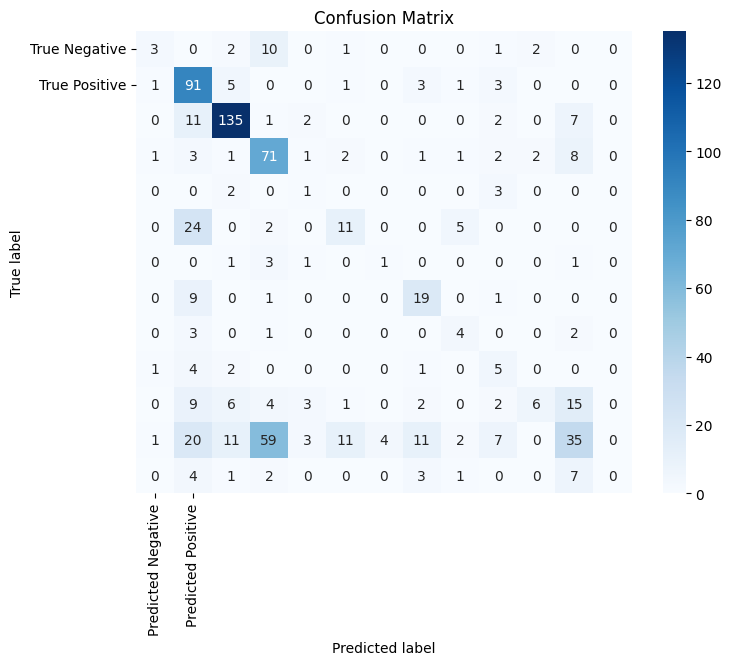

In [11]:
from sklearn.metrics import confusion_matrix

df.dropna(subset=['Generated Label (Number)', 'LABEL'], inplace=True)

y_true = df['LABEL']
y_pred = df['Generated Label (Number)']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import classification_report

y_true = df['LABEL']
y_pred = df['Generated Label (Number)']

report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 14)])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.16      0.23        19
           2       0.51      0.87      0.64       105
           3       0.81      0.85      0.83       158
           4       0.46      0.76      0.57        93
           5       0.09      0.17      0.12         6
           6       0.41      0.26      0.32        42
           7       0.20      0.14      0.17         7
           8       0.47      0.63      0.54        30
           9       0.29      0.40      0.33        10
          10       0.19      0.38      0.26        13
          11       0.60      0.12      0.21        48
          12       0.47      0.21      0.29       164
          13       0.00      0.00      0.00        18

    accuracy                           0.54       713
   macro avg       0.38      0.38      0.35       713
weighted avg       0.53      0.54      0.50       713



/Users/elyssa/.pyenv/versions/3.12.5/envs/is424_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elyssa/.pyenv/versions/3.12.5/envs/is424_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elyssa/.pyenv/versions/3.12.5/envs/is424_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Gemma Model for Mitigation Strategy Recommendations Generation

In [13]:
# import torch
# from transformers import pipeline

# pipe = pipeline(
#     "text-generation",
#     model="google/gemma-2-2b-it",
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device="mps",
# )

# for index in range(len(df)):
#     print("working on row ", str(index))
#     row = df.iloc[index]
#     article_title = row["Title"]

#     messages = [
#         {
#             "role": "user", 
#             "content": f"The title of a news article is '{article_title}', consider the actual news article and make one recommendation of mitigation strategies specific to Singapore context. Keep it brief."},
#     ]

#     outputs = pipe(messages, max_new_tokens=256)
#     assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
#     print(assistant_response)
#     df.at[index, 'Generated Recommendation'] = assistant_response

In [14]:
# df[['Title', 'Generated Recommendation']]